In [1]:
# INTEL CORPORATION CONFIDENTIAL AND PROPRIETARY
# 
# Copyright © 2019-2021 Intel Corporation.
# 
# This software and the related documents are Intel copyrighted
# materials, and your use of them is governed by the express 
# license under which they were provided to you (License). Unless
# the License provides otherwise, you may not use, modify, copy, 
# publish, distribute, disclose or transmit  this software or the
# related documents without Intel's prior written permission.
# 
# This software and the related documents are provided as is, with
# no express or implied warranties, other than those that are 
# expressly stated in the License.

## Implementation of a multi-compartment neuron with self-reward feedback

We consider a two-compartment neuron being driven by a spike generator as shown below. The synaptic weight connecting the spike generator to the dendritic compartment is learnt by feeding back the soma spikes through a reinforcement channel. This way, the synapse gets reward spikes from soma, and learns to synchronise spikes between the dendrite and the soma (i.e., when dendrite spikes, soma spikes as well, and vice versa).<br>

After a while, the system is expected to reach a steady state and synaptic weight is supposed to stabilise to a fixed value.

_Please read the comments in the code as well._

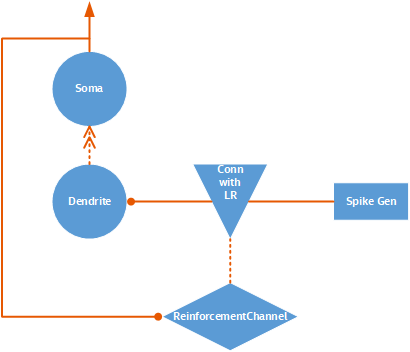

In [2]:
%config IPCompleter.greedy=True
import matplotlib.pyplot as plt
import numpy as np
import nxsdk.api.n2a as nx
%matplotlib notebook

#### Translation functions for parameters

In [3]:
# leak
def decay_from_tau(tau):
    val = int(1./tau * 2**12)
    print('decay={0} from tau={1}'.format(val, tau))
    return val

# synaptic time constant
def current_decay_from_tau(tau):
    val = int(1./tau * 2**12)
    print('current-decay={0} from tau={1}'.format(val, tau))
    return val    

# voltage threshold
def vthmant_from_vth(vth):
    val = int(vth / 2**6)
    print('vthMant={0} from vth={1}'.format(val, vth))
    return val

# bias current
def biasmant_from_bias(bias, biasExp=0):
    val = int(bias / 2**biasExp)
    print ('biasMant={0} from biasExp={1} and bias={2}'.format(val, biasExp, bias))
    return val

#### Instantiate NxNet

In [4]:
net = nx.NxNet()

#### Instantiate all required compartment prototypes

In [5]:
# Soma prototype
somaProto = nx.CompartmentPrototype(biasMant=biasmant_from_bias(0),
                                    vThMant=vthmant_from_vth(1500),                              
                                    compartmentVoltageDecay=decay_from_tau(1.1), # soma time constants are as small as
                                    compartmentCurrentDecay=decay_from_tau(1.1), # possible so that it responds quickly
                                    refractoryDelay=1,
                                    functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                    thresholdBehavior=nx.COMPARTMENT_THRESHOLD_MODE.SPIKE_AND_RESET,
                                    enableSpikeBackprop=0
                                   )

# Dendrite prototype
dendProto = nx.CompartmentPrototype(biasMant=biasmant_from_bias(0),
                                    vThMant=vthmant_from_vth(1500),  # threshold for the dendrite is same as soma
                                    compartmentVoltageDecay=decay_from_tau(10),
                                    compartmentCurrentDecay=decay_from_tau(10),
                                    refractoryDelay=1,
                                    functionalState=nx.COMPARTMENT_FUNCTIONAL_STATE.IDLE,
                                    thresholdBehavior=nx.COMPARTMENT_THRESHOLD_MODE.SPIKE_AND_RESET,
                                    enableSpikeBackprop=1,
                                    enableSpikeBackpropFromSelf=1
                                   )

biasMant=0 from biasExp=0 and bias=0
vthMant=23 from vth=1500
decay=3723 from tau=1.1
decay=3723 from tau=1.1
biasMant=0 from biasExp=0 and bias=0
vthMant=23 from vth=1500
decay=409 from tau=10
decay=409 from tau=10


#### Instantiate learning rules and connection prototypes

In [6]:
lr = net.createLearningRule(dt='2^-6*u0*y1-2^-6*u0*t', # Dummy tag variable tracks the post-trace y1. Because, there is no post-trace probe to do this. It is not used in actual learning.
                            dw='2^-5*u0*r1*x1-2^-6*u0*y1*x1', 
                            x1Impulse=50,
                            x1TimeConstant=10,
                            y1Impulse=40,
                            y1TimeConstant=10,
                            r1Impulse=40,
                            r1TimeConstant=10,
                            tEpoch=1)  # Note: The fixed point approximation of exponential decay is less accurate if tEpoch=1
connProtoLearn = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED, 
                                        weight=30, 
                                        weightExponent=-1,
                                        enableLearning=1,
                                        learningRule=lr,
                                        numTagBits=8)  # High precision tag variable to keep track of y1
connProtoGeneric = nx.ConnectionPrototype(signMode=nx.SYNAPSE_SIGN_MODE.MIXED)

#### Create a neuron prototype and instantiate a neuron

In [7]:
somaProto.addDendrite(dendProto, nx.COMPARTMENT_JOIN_OPERATION.ADD)
neuronProto = nx.NeuronPrototype(somaProto)
neuron = net.createNeuron(neuronProto)

#### Spike generator

In [8]:
steps = 2000
spikegen = net.createSpikeGenProcess(numPorts=1)
inputs = list(range(90, steps+10, 100))
spikegen.addSpikes(spikeInputPortNodeIds=0,spikeTimes=inputs)

#### Connect everything as needed

In [9]:
connSpkGenToDend = spikegen.connect(neuron.dendrites[0], prototype=connProtoLearn)
connSomaToRnfCh = neuron.soma.connect(lr.reinforcementChannel, prototype=connProtoGeneric)

#### Setup probes

In [10]:
vProbeSoma, uProbeSoma, sProbeSoma = neuron.soma.probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                        nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                        nx.ProbeParameter.SPIKE])
vProbeDend, uProbeDend, sProbeDend = neuron.dendrites[0].probe([nx.ProbeParameter.COMPARTMENT_VOLTAGE,
                                                                nx.ProbeParameter.COMPARTMENT_CURRENT,
                                                                nx.ProbeParameter.SPIKE])
rewardProbe = connSomaToRnfCh.probe([nx.ProbeParameter.REWARD_TRACE])
tagProbe  = connSpkGenToDend.probe([nx.ProbeParameter.SYNAPSE_TAG])
weightProbe  = connSpkGenToDend.probe([nx.ProbeParameter.SYNAPSE_WEIGHT])

#### Run and plot

In [11]:
net.run(steps)
net.disconnect()

fig = plt.figure(1, figsize=[10, 10])
ax0 = plt.subplot(6, 1, 1)
rewardProbe[0].plot()
plt.title('Reward traces')
ax1 = plt.subplot(6, 1, 2, sharex=ax0)
weightProbe[0][0].plot()
tagProbe[0][0].plot()
plt.title('Learning synapse weight and (tag = y1/2^-6)')  # tag variable saturates at 8-bits. y1 might be going beyond that.
ax2 = plt.subplot(6, 1, 3, sharex=ax0)
vProbeSoma.plot()
vProbeDend.plot()
plt.title('Compartment voltage')
ax2 = plt.subplot(6, 1, 4, sharex=ax0)
uProbeSoma.plot()
uProbeDend.plot()
plt.title('Compartment current')
ax3 = plt.subplot(6, 1, 5, sharex=ax0)
sProbeSoma.plot()
plt.title('Soma Spikes')
ax3 = plt.subplot(6, 1, 6, sharex=ax0)
sProbeDend.plot()
plt.title('Dend Spikes')
fig.tight_layout()

INFO:DRV:  SLURM is being run in background
INFO:HST:  /home/szzhu/nxsdk-nxsdk/nxsdk/driver/../bin/nx_driver_server: 16: exec: /home/szzhu/nxsdk-nxsdk/nxsdk/driver/../bin/x86/nx_driver_server: not found
INFO:HST:  srun: error: ncl-nuc-01: task 0: Exited with exit code 127
INFO:DRV:      Host server up..............Done 259.46s
INFO:DRV:  Executor: 2000 timesteps........Done 259.46s


KeyboardInterrupt: 